In [4]:
import jax
import jax.numpy as np
import jax.random as jnp_random
import numpy as onp
from jax import grad, jacrev, jacfwd, jit, vmap, partial
from jax.scipy.special import logsumexp
from jax.lax import scan
from jax.experimental import optimizers
from jax.numpy import concatenate as cat
import timeit

import random
import pickle as pkl
import scipy

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
@jit
def p(x): # uniform distribution
    return np.exp(-50.5 * np.sum((x[:2] - 0.2)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - 0.75)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - np.array([0.2, 0.75]))**2))

@jit
def f(x, u): # dynamics
    xnew = x + np.tanh(u)
    return xnew, x

def get_hk(k): # normalizing factor for basis function
    _hk = (2. * k + onp.sin(2 * k))/(4. * k)
    _hk[onp.isnan(_hk)] = 1.
    return onp.sqrt(onp.prod(_hk))

def fk(x, k): # basis function
    return np.prod(np.cos(x*k))


k1, k2 = np.meshgrid(*[np.arange(0, 6, step=1)]*2)
k = np.stack([k1.ravel(), k2.ravel()]).T
k = np.pi*k

lamk = (1.+np.linalg.norm(k/np.pi,axis=1)**2)**(-4./2.)
# lamk = np.exp(-0.8 * np.linalg.norm(k, axis=1))
# lamk = np.ones((len(k), 1))
hk = []
for ki in k:
    hk.append(get_hk(ki))
hk = np.array(hk)

fk_vmap = lambda _x, _k: vmap(fk, in_axes=(0,None))(_x, _k)
def get_ck(tr, k):
    ck = np.mean(vmap(partial(fk_vmap, tr))(k), axis=1)
    ck = ck / hk
    return ck

# @jit
def fourier_ergodic_loss(u, x0, phik, k):
    xf, tr = scan(f, x0, u)
    ck = get_ck(tr, k)
    return np.sum(lamk*np.square(phik - ck)) \
            + 1e-3 * np.mean(u**2) + np.mean((tr - np.array([0.5,0.5]))**8)

dl = jit(grad(fourier_ergodic_loss))

/home/burn/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
<ipython-input-5-2de74295d465>:13: RuntimeWarning: invalid value encountered in true_divide
  _hk = (2. * k + onp.sin(2 * k))/(4. * k)


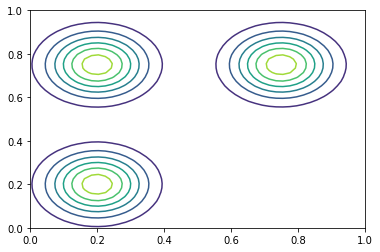

In [6]:
X,Y = np.meshgrid(*[np.linspace(0,1)]*2)
_s = np.stack([X.ravel(), Y.ravel()]).T
plt.contour(X, Y, vmap(p)(_s).reshape(X.shape))

In [7]:
phik = np.dot(vmap(fk_vmap, in_axes=(None, 0))(_s, k), vmap(p)(_s))
phik = phik/phik[0]
phik = phik/hk

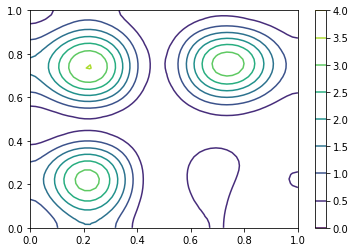

In [8]:
phik_recon = np.dot(phik, vmap(fk_vmap, in_axes=(None, 0))(_s, k)).reshape(X.shape)
plt.contour(X, Y, phik_recon)
plt.colorbar()

In [9]:
# initial conditions
x0 = np.array([0.54,0.3])
u  = np.zeros((50,2))

In [10]:
fourier_ergodic_loss(u, x0, phik, k)

DeviceArray(0.6590002, dtype=float32)

In [11]:
opt_init, opt_update, get_params = optimizers.adam(1e-3)
opt_state = opt_init(u)

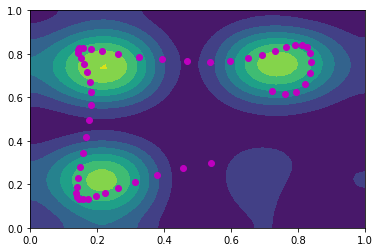

In [12]:
log = []
for i in range(1500):
    g = dl(get_params(opt_state), x0, phik, k)
    opt_state = opt_update(i, g, opt_state)
    
    if (i+1) % 100 == 0:
        u = get_params(opt_state)
        log.append(fourier_ergodic_loss(u, x0, phik, k).copy())
        clear_output(wait=True)
        xf, tr = scan(f, x0, u)
        
        clear_output(wait=True)
        plt.contourf(X, Y, phik_recon)
        plt.scatter(tr[:,0],tr[:,1], c='m')
#         plt.ylim(0,1)
#         plt.xlim(0,1)
        plt.pause(0.001)
        i+=1
        plt.show()


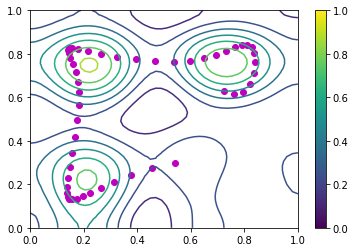

In [13]:
# ck reconstruction
ck = get_ck(tr, k)
ck_recon = np.dot(ck, vmap(fk_vmap, in_axes=(None, 0))(_s, k)).reshape(X.shape)
plt.contour(X, Y, ck_recon)
plt.scatter(tr[:,0],tr[:,1], c='m')
plt.colorbar()